In [2]:
%env AZURE_EXTENSION_DIR=/home/schrodinger/automl/sdk-cli-v2/src/cli/src
%env AZURE_ML_CLI_PRIVATE_FEATURES_ENABLED=true

env: AZURE_EXTENSION_DIR=/home/schrodinger/automl/sdk-cli-v2/src/cli/src
env: AZURE_ML_CLI_PRIVATE_FEATURES_ENABLED=true


# Problem

The dataset in this experiment is taken from a Kaggle competition sponsored by Porto Seguro, one of the largest auto and homeowner insurance companies in Brazil. Given an anonymized dataset about drivers, cars etc., the challenge is to build a model that predicts the probability that a driver will initiate an auto insurance claim in the next year.

Kaggle link: https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/overview

# Imports

In [2]:
import os

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

# pandas options
pd.set_option("display.max_columns", None)
pd.set_option('display.max_colwidth', 5000)
pd.options.display.float_format = "{:.5f}".format

# Load Data

The training dataset has been uploaded to an Azure Blob Store, from where we can download and process it directly using Pandas.

In [3]:
train_df = pd.read_csv(
    "https://azmlworkshopdata.blob.core.windows.net/safedriverdata/porto_seguro_safe_driver_prediction_train.csv",
    index_col="id")
train_df.head()

,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
7,0,2,2,5,1,0,0,1,0,0,0,0,0,0,0,11,0,1,0,0.70000,0.20000,0.71807,10,1,-1,0,1,4,1,0,0,1,12,2,0.40000,0.88368,0.37081,3.60555,0.60000,0.50000,0.20000,3,1,10,1,10,1,5,9,1,5,8,0,1,1,0,0,1
9,0,1,1,7,0,0,0,0,1,0,0,0,0,0,0,3,0,0,1,0.80000,0.40000,0.76608,11,1,-1,0,-1,11,1,1,2,1,19,3,0.31623,0.61882,0.38872,2.44949,0.30000,0.10000,0.30000,2,1,9,5,8,1,7,3,1,1,9,0,1,1,0,1,0
13,0,5,4,9,1,0,0,0,1,0,0,0,0,0,0,12,1,0,0,0.00000,0.00000,-1.00000,7,1,-1,0,-1,14,1,1,2,1,60,1,0.31623,0.64159,0.34728,3.31662,0.50000,0.70000,0.10000,2,2,9,1,8,2,7,4,2,7,7,0,1,1,0,1,0
16,0,0,1,2,0,0,1,0,0,0,0,0,0,0,0,8,1,0,0,0.90000,0.20000,0.58095,7,1,0,0,1,11,1,1,3,1,104,1,0.37417,0.54295,0.29496,2.00000,0.60000,0.90000,0.10000,2,4,7,1,8,4,2,2,2,4,9,0,0,0,0,0,0
17,0,0,2,0,1,0,1,0,0,0,0,0,0,0,0,9,1,0,0,0.70000,0.60000,0.84076,11,1,-1,0,-1,14,1,1,2,1,82,3,0.31607,0.56583,0.36510,2.00000,0.40000,0.60000,0.00000,2,2,6,3,10,2,12,3,1,1,3,0,0,0,1,1,0


The features have been named in such a way that they indicate the type of the feature.
- The feature that we want to predict is named as 'target' 
- Features with 'bin' are binary features (i.e. have 0 or 1 values)
- Feaures with 'cat' are categorical features
- Features with 'calc' are engineered (calculated) columns
- Remaining features are numerical (continuous)

Also, all missing values are already imputed by a common value of -1.


In [4]:
def dtype_dist(df):
    def _l(x): return "{%s}" % ', '.join(x["index"])
    return df.dtypes.reset_index(name="dtype").groupby(
        ["dtype"]).apply(lambda x: _l(x)).reset_index(name="feature")

dtype_dist(train_df)

,dtype,feature
0,int64,"{target, ps_ind_01, ps_ind_02_cat, ps_ind_03, ps_ind_04_cat, ps_ind_05_cat, ps_ind_06_bin, ps_ind_07_bin, ps_ind_08_bin, ps_ind_09_bin, ps_ind_10_bin, ps_ind_11_bin, ps_ind_12_bin, ps_ind_13_bin, ps_ind_14, ps_ind_15, ps_ind_16_bin, ps_ind_17_bin, ps_ind_18_bin, ps_car_01_cat, ps_car_02_cat, ps_car_03_cat, ps_car_04_cat, ps_car_05_cat, ps_car_06_cat, ps_car_07_cat, ps_car_08_cat, ps_car_09_cat, ps_car_10_cat, ps_car_11_cat, ps_car_11, ps_calc_04, ps_calc_05, ps_calc_06, ps_calc_07, ps_calc_08, ps_calc_09, ps_calc_10, ps_calc_11, ps_calc_12, ps_calc_13, ps_calc_14, ps_calc_15_bin, ps_calc_16_bin, ps_calc_17_bin, ps_calc_18_bin, ps_calc_19_bin, ps_calc_20_bin}"
1,float64,"{ps_reg_01, ps_reg_02, ps_reg_03, ps_car_12, ps_car_13, ps_car_14, ps_car_15, ps_calc_01, ps_calc_02, ps_calc_03}"


# Exploratory Data Analysis

In [4]:
X = train_df.drop("target", axis=1)
y = train_df["target"]

X.shape

(595212, 57)

In [5]:
# separate features based on types
cat_features = [c for c in X.columns if '_cat' in c]
bin_features = [c for c in X.columns if '_bin' in c]
num_features = list(set(X.columns) - set(cat_features + bin_features))

## Target Imbalance
The target value is highly skewed, i.e., there are far less individuals which claimed insurace (target=1) than those who didn't (target=0). This means that we might have to use advanced methods, like upsampling, to make the model learn the behavior of the minority class, and not just always predict the majority class.

0    573518
1     21694
Name: target, dtype: int64

<AxesSubplot:xlabel='target', ylabel='count'>

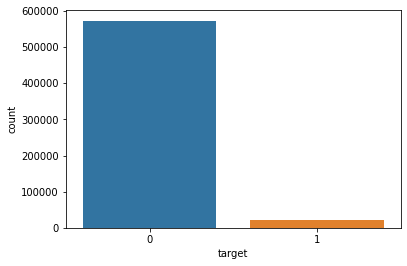

In [62]:
display(y.value_counts())
sns.countplot(x=y)

## Feature Correlations

Understanding feature correlations can help us figure out complex relationships between features (e.g. if they are positively or negatively correlated, or neutral - not dependent on each other at all), and ultimately help in narrowing our choices for model selection. For instance, Linear models (like LinearRegression) may not work well for two or more features that are tightly correlated, and may require some processing (e.g. dropping) before these models can work effectively on them.

The below graphs show the pearson correlations among the features (grouped by their type). The values range from -1 (strong negative correlation) to 1 (strong positive correlation) with 0 being neutral.
There aren't features that are very tightly correlated to each other - which means we don't worry too much about them.

<AxesSubplot:title={'center':'Correlation between categorical features'}>

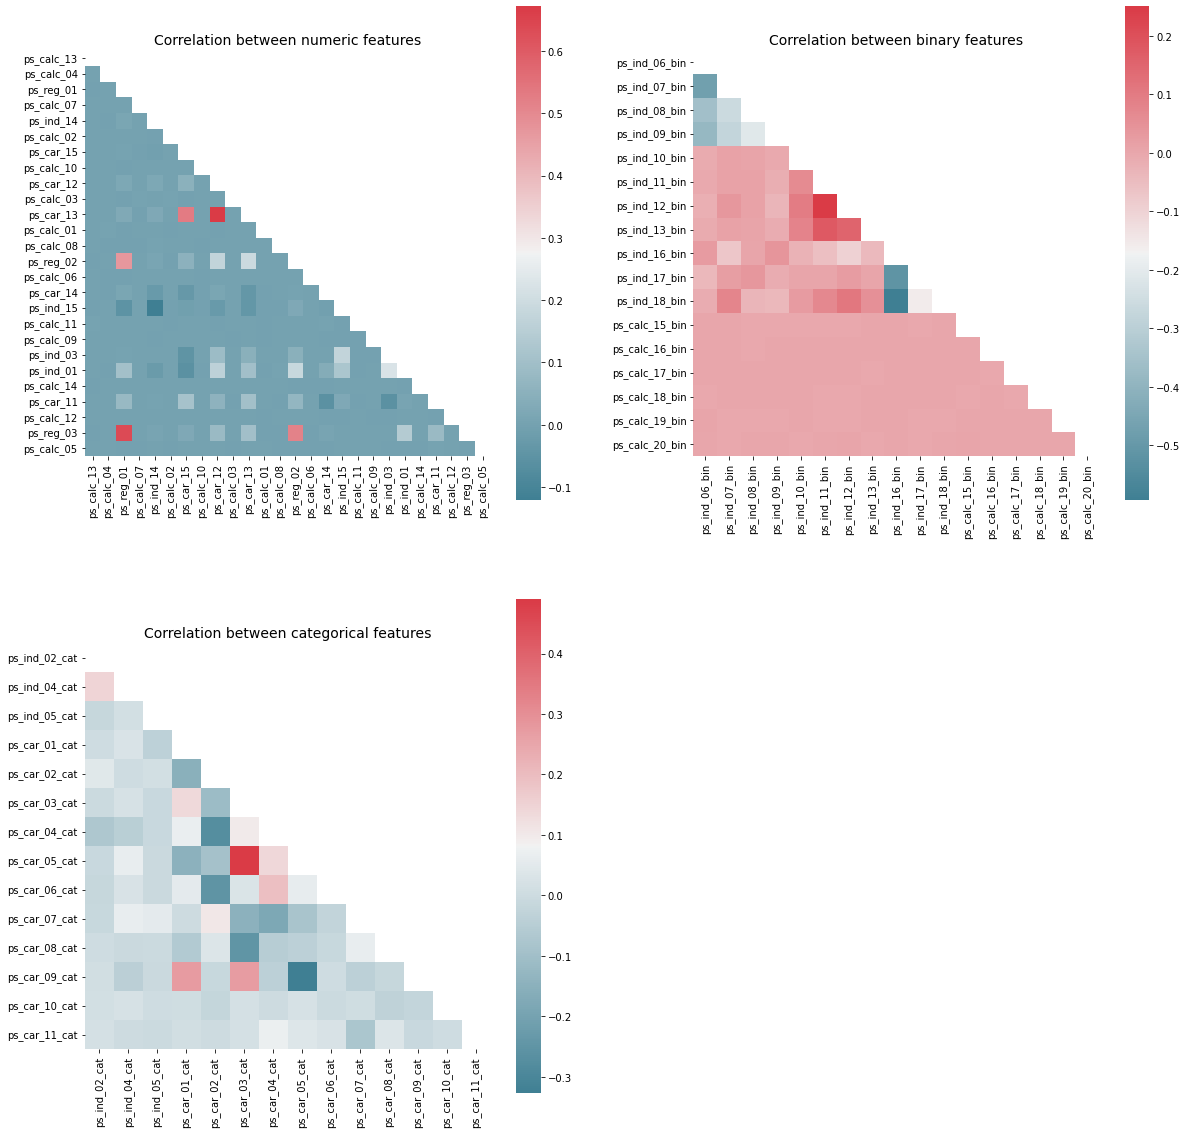

In [64]:
def get_masked_corr(df):
    corr = df.corr(method='pearson')
    mask = np.zeros_like(corr, dtype=bool)   # Mask for hiding the upper half of the diagonal
    mask[np.triu_indices_from(mask)] = True
    corr[mask] = np.nan
    return corr


fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(20,20))
axs[1, 1].set_visible(False)

corr = get_masked_corr(X[num_features])
axs[0, 0].set_title("Correlation between numeric features", fontsize=14)
sns.heatmap(corr, cmap=sns.diverging_palette(220, 10, as_cmap=True), square=True, ax=axs[0, 0])

corr = get_masked_corr(X[bin_features])
axs[0, 1].set_title("Correlation between binary features", fontsize=14)
sns.heatmap(corr, cmap=sns.diverging_palette(220, 10, as_cmap=True), square=True, ax=axs[0, 1])

corr = get_masked_corr(X[cat_features])
axs[1, 0].set_title("Correlation between categorical features", fontsize=14)
sns.heatmap(corr, cmap=sns.diverging_palette(220, 10, as_cmap=True),square=True, ax=axs[1, 0])


## Missing Values

The dataset contains missing values, which are populated by the value -1. These would need to be handled separately (e.g. by filling them with appropriate values, adding missing value indicators etc.)

We will convert them to np.nan, which can later be handled by the featurization pipeline.

In [66]:
summary = X.describe()
summary

,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,595212.00000,595212.00000,595212.00000,595212.00000,595212.00000,595212.00000,595212.00000,595212.00000,595212.00000,595212.00000,595212.00000,595212.00000,595212.00000,595212.00000,595212.00000,595212.00000,595212.00000,595212.00000,595212.00000,595212.00000,595212.00000,595212.00000,595212.00000,595212.00000,595212.00000,595212.00000,595212.00000,595212.00000,595212.00000,595212.00000,595212.00000,595212.00000,595212.00000,595212.00000,595212.00000,595212.00000,595212.00000,595212.00000,595212.00000,595212.00000,595212.00000,595212.00000,595212.00000,595212.00000,595212.00000,595212.00000,595212.00000,595212.00000,595212.00000,595212.00000,595212.00000,595212.00000,595212.00000,595212.00000,595212.00000,595212.00000,595212.00000
mean,1.90038,1.35894,4.42332,0.41679,0.40519,0.39374,0.25703,0.16392,0.18530,0.00037,0.00169,0.00944,0.00095,0.01245,7.29992,0.66082,0.12108,0.15345,0.61099,0.43918,0.55110,8.29593,0.82993,-0.50490,0.72519,-0.15773,6.55534,0.91003,0.83208,1.32889,0.99214,62.21567,2.34607,0.37994,0.81326,0.27626,3.06590,0.44976,0.44959,0.44985,2.37208,1.88589,7.68945,3.00582,9.22590,2.33903,8.43359,5.44138,1.44192,2.87229,7.53903,0.12243,0.62784,0.55418,0.28718,0.34902,0.15332
std,1.98379,0.66459,2.69990,0.49331,1.35064,0.48858,0.43700,0.37020,0.38854,0.01931,0.04110,0.09669,0.03077,0.12754,3.54604,0.47343,0.32622,0.36042,0.28764,0.40426,0.79351,2.50827,0.37572,0.78865,2.15346,0.84442,5.50144,0.34711,0.37380,0.97875,0.09162,33.01246,0.83255,0.05833,0.22459,0.35715,0.73137,0.28720,0.28689,0.28715,1.11722,1.13493,1.33431,1.41456,1.45967,1.24695,2.90460,2.33287,1.20296,1.69489,2.74665,0.32778,0.48338,0.49706,0.45245,0.47666,0.36029
min,0.00000,-1.00000,0.00000,-1.00000,-1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,-1.00000,-1.00000,-1.00000,-1.00000,0.00000,-1.00000,0.00000,-1.00000,0.00000,-1.00000,0.00000,1.00000,-1.00000,-1.00000,0.25062,-1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,2.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
25%,0.00000,1.00000,2.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,5.00000,0.00000,0.00000,0.00000,0.40000,0.20000,0.52500,7.00000,1.00000,-1.00000,0.00000,-1.00000,1.00000,1.00000,1.00000,0.00000,1.00000,32.00000,2.00000,0.31623,0.67087,0.33317,2.82843,0.20000,0.20000,0.20000,2.00000,1.00000,7.00000,2.00000,8.00000,1.00000,6.00000,4.00000,1.00000,2.00000,6.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
50%,1.00000,1.00000,4.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,7.00000,1.00000,0.00000,0.00000,0.70000,0.30000,0.72068,7.00000,1.00000,-1.00000,0.00000,0.00000,7.00000,1.00000,1.00000,2.00000,1.00000,65.00000,3.00000,0.37417,0.76581,0.36878,3.31662,0.50000,0.40000,0.50000,2.00000,2.00000,8.00000,3.00000,9.00000,2.00000,8.00000,5.00000,1.00000,3.00000,7.00000,0.00000,1.00000,1.00000,0.00000,0.00000,0.00000
75%,3.00000,2.00000,6.00000,1.00000,0.00000,1.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,10.00000,1.00000,0.00000,0.00000,0.90000,0.60000,1.00000,11.00000,1.00000,0.00000,0.00000,1.00000,1

In [84]:
cols_missing_vals = list(summary.T[summary.T["missing"] == -1].T.columns)
print("The following columns contain missing values: ", cols_missing_vals)

print("\nReplacing with np.nan")
X[cols_missing_vals] = X[cols_missing_vals].replace(-1, np.nan)

assert (X.describe().loc["min"] ==  -1).sum() == 0, "Missing values were not replaced with np.nan"

The following columns contain missing values:  ['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_reg_03', 'ps_car_01_cat', 'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_05_cat', 'ps_car_07_cat', 'ps_car_09_cat', 'ps_car_11', 'ps_car_12', 'ps_car_14']

Replacing with np.nan


A large percent of missing values in some columns (e.g. ps_car_03_cat, ps_car_05_cat) indicates that this can be encoded as a separate feature (e.g. by adding a missing values indicator column)

In [116]:
percent_missing = X[cols_missing_vals].isnull().mean() *100
percent_missing_df = pd.DataFrame({'column_name': cols_missing_vals, 'percent_missing': percent_missing}).reset_index(drop=True)
display(percent_missing_df.sort_values(by='percent_missing', ascending=False))

,column_name,percent_missing
6,ps_car_03_cat,69.08984
7,ps_car_05_cat,44.78253
3,ps_reg_03,18.10649
12,ps_car_14,7.16047
8,ps_car_07_cat,1.93024
2,ps_ind_05_cat,0.97595
9,ps_car_09_cat,0.09560
0,ps_ind_02_cat,0.03629
4,ps_car_01_cat,0.01798
1,ps_ind_04_cat,0.01394


## Binary Features

### Distribution

Most of the binary features are skweed, and appear to be dominated by a single class (0).

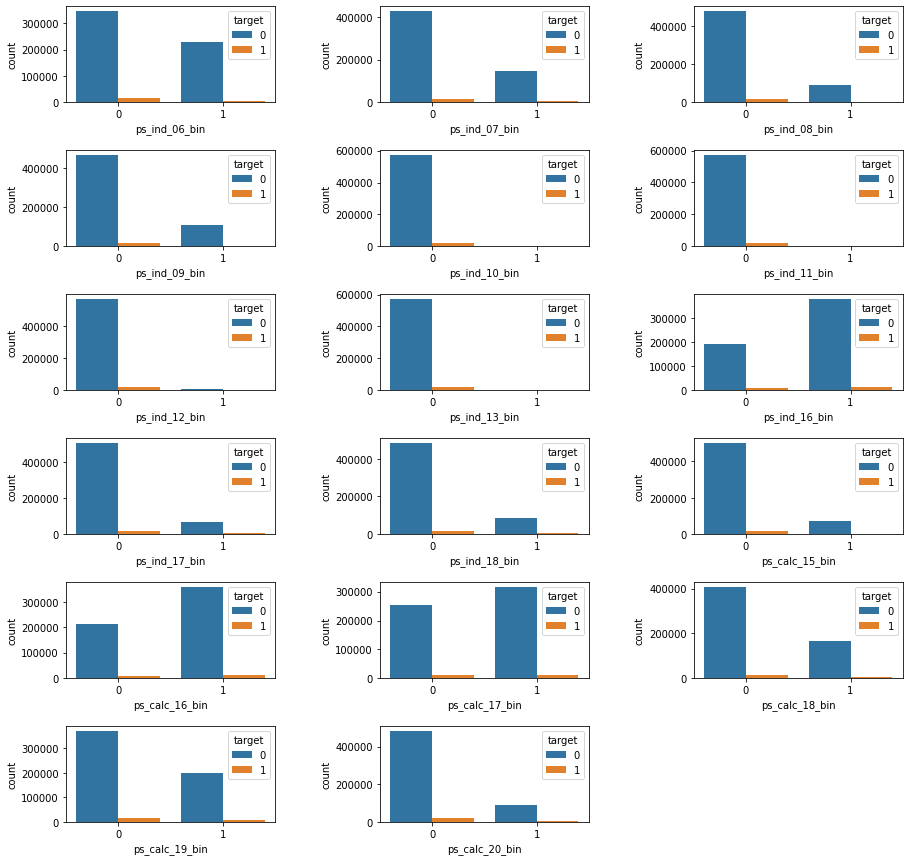

In [60]:
columns = X[bin_features].columns.values

# Calculating required amount of rows to display all feature plots
cols = 3
rows = 6

fig, axs = plt.subplots(ncols=cols, nrows=rows, figsize=(15,15))

# Adding some distance between plots
plt.subplots_adjust(hspace = 0.5, wspace = 0.5)

for i, col in enumerate(columns):
    r = i // cols
    c = i % cols
    sns.countplot(x=col, data=X[bin_features], hue=y, ax=axs[r][c])

axs[r, c+1].set_visible(False)    # Hide the last (empty) plot

## Categorical Features

### Cardinalities

If the threshold for high cardinality column is considered to be 10 or more, it seems we have four high cardinality columns - ps_car_11_cat, ps_car_06_cat, ps_car_04_cat, ps_car_01_cat, with ps_car_11_cat having more than 100 categories.

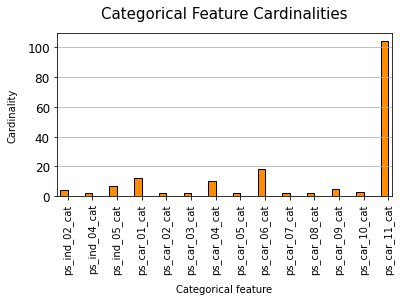

In [100]:
bars_pos = np.arange(len(cat_features))

width=0.3
fig, ax = plt.subplots(figsize=(6, 3))

bars = ax.bar(bars_pos-width/2, X[cat_features].nunique().values, width=width,
              color="darkorange", edgecolor="black")

ax.set_title("Categorical Feature Cardinalities", fontsize=15, pad=15)
ax.set_xlabel("Categorical feature", fontsize=10, labelpad=10)
ax.set_ylabel("Cardinality", fontsize=10, labelpad=10)
ax.set_xticks(bars_pos)
ax.set_xticklabels(cat_features, rotation=90, fontsize=10)
ax.tick_params(axis="y", labelsize=12)
ax.grid(axis="y")
plt.margins(0.01, 0.05)

### Distribution

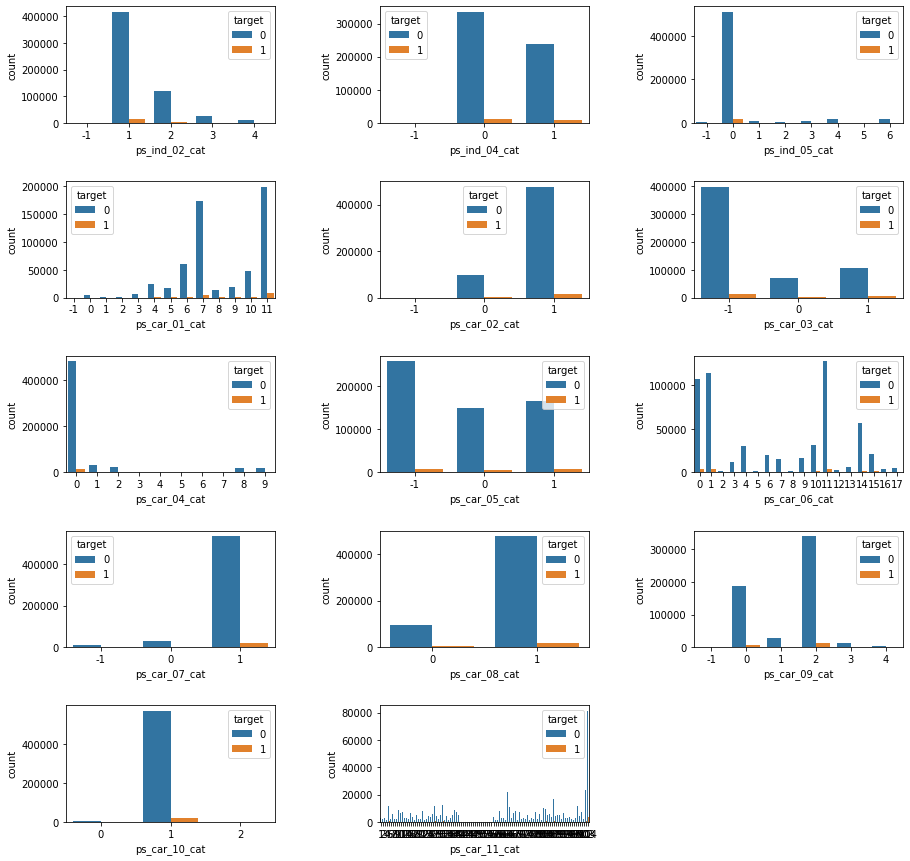

In [63]:
columns = X[cat_features].columns.values

# Calculating required amount of rows to display all feature plots
cols = 3
rows = 5

fig, axs = plt.subplots(ncols=cols, nrows=rows, figsize=(15,15))

# Adding some distance between plots
plt.subplots_adjust(hspace = 0.5, wspace = 0.5)

for i, col in enumerate(columns):
    r = i // cols
    c = i % cols
    sns.countplot(x=col, data=X[cat_features], hue=y, ax=axs[r][c])

axs[r, c+1].set_visible(False)    # Hide the last (empty) plot

## Numerical Features

### Distribution

The distribution below shows that most features (like ps_reg_15, ps_car_11, ps_ind_01, ps_reg_01) contains only a few unique values. Perhaps it could also be treated as categorical?

A few other columns, most predominantly ps_ind_14, is dominated by a single value (0).

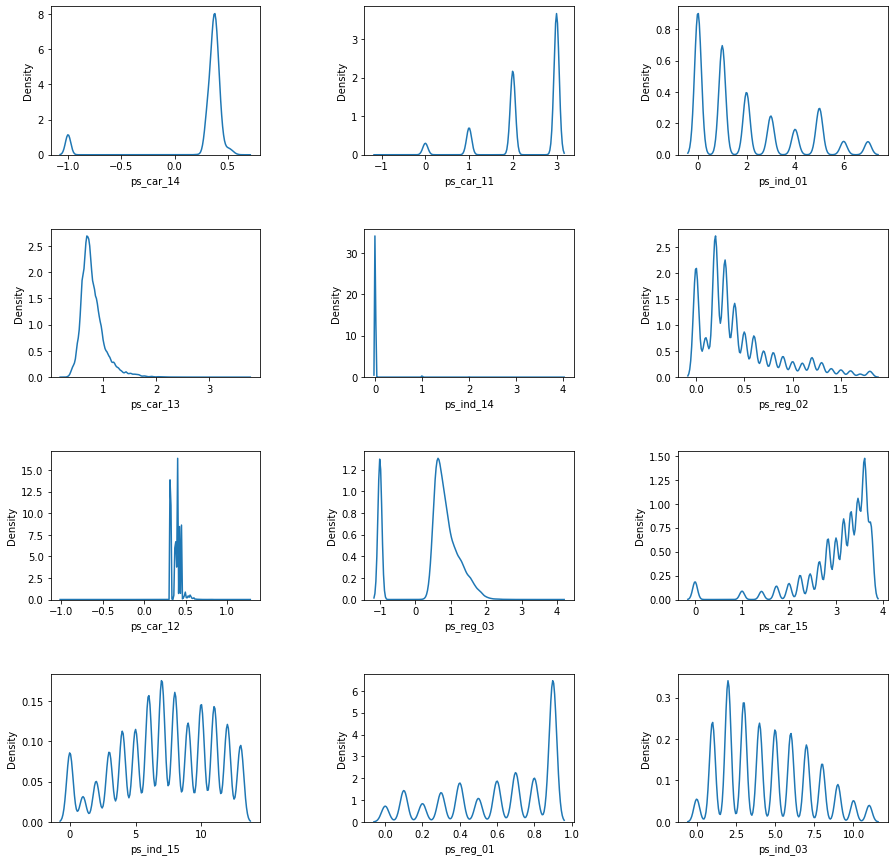

In [65]:
only_nums = [c for c in num_features if '_calc' not in c]
columns = X[only_nums].columns.values

# Calculating required amount of rows to display all feature plots
cols = 3
rows = 4

fig, axs = plt.subplots(ncols=cols, nrows=rows, figsize=(15,15))

# Adding some distance between plots
plt.subplots_adjust(hspace = 0.5, wspace = 0.5)

for i, col in enumerate(columns):
    r = i // cols
    c = i % cols
    sns.kdeplot(x=col, data=X[columns], ax=axs[r][c])

# Preprocessing

Based on the exploratory data analysis above, we now numercalize the data.

This is the place that will distill the above findings into an AutoML Featurization Config, and create a featurization job to get the preprocessed dataset.

## Split training data into train and valid splits

In [9]:
train_df, valid_df = train_test_split(train_df, test_size=0.2, random_state=42)
train_df.shape, valid_df.shape

((476169, 58), (119043, 58))

## Featurization

In [23]:
def featurize(df, valid_df, cat_features, num_features):
    from sklearn.preprocessing import OneHotEncoder
    from sklearn.preprocessing import StandardScaler
    
    encoder = OneHotEncoder(sparse=False)
    ohe_df = pd.DataFrame(encoder.fit_transform(df[cat_features]), columns=encoder.get_feature_names())
    
    ohe_df.index = df.index
    df = pd.concat([df, ohe_df], axis=1).drop(cat_features, axis=1)
    
    ohe_valid_df = pd.DataFrame(encoder.fit_transform(valid_df[cat_features]), columns=encoder.get_feature_names())
    ohe_valid_df.index = valid_df.index
    valid_df = pd.concat([valid_df, ohe_valid_df], axis=1).drop(cat_features, axis=1)
    
    scaler = StandardScaler()
    df[num_features] = scaler.fit_transform(df[num_features])
    valid_df[num_features] = scaler.transform(valid_df[num_features])
    
    return df, valid_df

train_df, valid_df = featurize(train_df, valid_df, cat_features, num_features)

## Save the files as CSV 
Save the CSV file locally, so that it can be uploaded to create a tabular dataset

In [32]:
if not os.path.isdir('data'):
    os.mkdir('data')
    
# Save the train-valid data to a csv to be uploaded to the datastore
train_df.to_csv("data/train_data.csv", index=False)
valid_df.to_csv("data/valid_data.csv", index=False)

# Data Loading in Azure ML

Once Tabular Datasets are available, the above CSV files can be used to generate Datasets, that can be fed into AutoML Training